In [1]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

DOLFINx version: 0.6.0 based on GIT commit:  of https://github.com/FEniCS/dolfinx/


In [1]:
from mpi4py import MPI
import numpy as np
from petsc4py.PETSc import ScalarType
from dolfinx.fem.petsc import LinearProblem
from dolfinx import mesh, io, fem
from dolfinx.fem import Function, FunctionSpace, dirichletbc, locate_dofs_geometrical, form
import ufl
from ufl import grad, div, nabla_grad, dx, inner, dot, Measure, FacetNormal, SpatialCoordinate, TestFunctions, TrialFunctions, div, exp, inner

domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

P2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1)
Ve = FunctionSpace(domain, P2)
Pe = FunctionSpace(domain, P1)
TH = P2 * P1
V = FunctionSpace(domain, TH)
(v_a, p_a) = ufl.TrialFunctions(V)
(v_t, p_t) = ufl.TestFunctions(V)
V0, _ = V.sub(0).collapse()
V00, _ = V0.sub(0).collapse()
V01, _ = V0.sub(1).collapse()
V1, _ = V.sub(1).collapse()

x = SpatialCoordinate(domain)
U = 1.0

In [2]:
def v_exact(x):
    #x_array = np.array(x[0])
    #y_array = np.array(x[1])
    
    theta = np.arctan2(x[1], x[0])
    radius = (x[0]**2 + x[1]**2)**0.5
    Ue = -U
    theta0 = 0.5*np.pi
    f = Ue*(-theta0**2*np.sin(theta) + theta0*theta*np.sin(theta) \
           - np.sin(theta0)*np.cos(theta0)*theta*np.sin(theta) \
           + np.sin(theta0)**2*theta*np.cos(theta)) \
           /(theta0**2 - np.sin(theta0)**2)
    
    dfdt = Ue*(-theta0**2*np.cos(theta) + theta0*np.sin(theta) \
              + theta0*theta*np.cos(theta) - np.sin(theta0)*np.cos(theta0)*np.sin(theta) \
              - np.sin(theta0)*np.cos(theta0)*theta*np.cos(theta) \
              + np.sin(theta0)**2*np.cos(theta) - np.sin(theta0)**2*theta*np.sin(theta)) \
           /(theta0**2 - np.sin(theta0)**2)
    psie = radius*f
    vre = dfdt
    vte = -f
    ve = np.array([vre*np.cos(theta) - vte*np.sin(theta),
                   vre*np.sin(theta) + vte*np.cos(theta)])
    
    return ve

In [3]:
def left(x):
        return np.isclose(x[0], 0)
def base(x):
        return np.isclose(x[1], 0)
def topright(x):
        return np.logical_or(np.isclose(x[0], 1), np.isclose(x[1], 1))
def corner(x):
        return np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 0))

# locate the dofs for the various bcs
dofs_v_topright = locate_dofs_geometrical((V.sub(0), V0), topright)
dofs_v_left = locate_dofs_geometrical((V.sub(0), V0), left)
# split up v into v0 and v1 on the base to make it easier to apply a tangential bc
dofs_v0_base = locate_dofs_geometrical((V.sub(0).sub(0), V00), base)
dofs_v1_base = locate_dofs_geometrical((V.sub(0).sub(1), V01), base)
dofs_p_corner = locate_dofs_geometrical((V.sub(1), V1),  corner)

# set up v bcs
# base
U_v0 = Function(V00)
U_v0.x.set(U)
bc_v0_base = dirichletbc(U_v0, dofs_v0_base, V.sub(0).sub(0))
zero_v1 = Function(V01)
zero_v1.x.set(0.0)
bc_v1_base = dirichletbc(zero_v1, dofs_v1_base, V.sub(0).sub(1))
# left side
zero_v = Function(V0)
zero_v.x.set(0.0)
bc_v_left = dirichletbc(zero_v, dofs_v_left, V.sub(0))
# top and right
ve = Function(V0)
ve.interpolate(v_exact)
bc_v_topright = dirichletbc(ve, dofs_v_topright, V.sub(0))

# pressure bc (at an arbitrary point)
zero_p = Function(V1)
zero_p.x.set(100.0)
bc_p_corner = dirichletbc(zero_p, dofs_p_corner, V.sub(1))

zero_c = fem.Constant(domain, ScalarType(0.0))

# weak forms
K = ufl.inner(ufl.sym(ufl.grad(v_t)), ufl.sym(ufl.grad(v_a)))*ufl.dx 
G = -ufl.div(v_t)*p_a*ufl.dx
D = -p_t*ufl.div(v_a)*ufl.dx
S = K + G + D

# I used the following form to make sure that the bcs were being applied correctly
# (they were and I'm just leaving this here as a note)
#S = ufl.inner(v_t, v_a)*ufl.dx + p_t*p_a*ufl.dx

L = zero_c * v_t[0] * ufl.dx

problem = LinearProblem(S, L, bcs=[bc_p_corner, bc_v_topright, bc_v_left, bc_v0_base, bc_v1_base], \
                        petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
u_i = problem.solve()


In [4]:
from dolfinx import io
v = u_i.sub(0).collapse()
v.name = "Velocity"
p = u_i.sub(1).collapse()
p.name = "Pressure"
ve.name = "ExactVelocity"
with io.VTKFile(domain.comm, "output_v.pvd", "w") as vtk:
    vtk.write_function([v, ve], 0.0)
with io.VTKFile(domain.comm, "output_p.pvd", "w") as vtk:
    vtk.write_function([p], 0.0)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



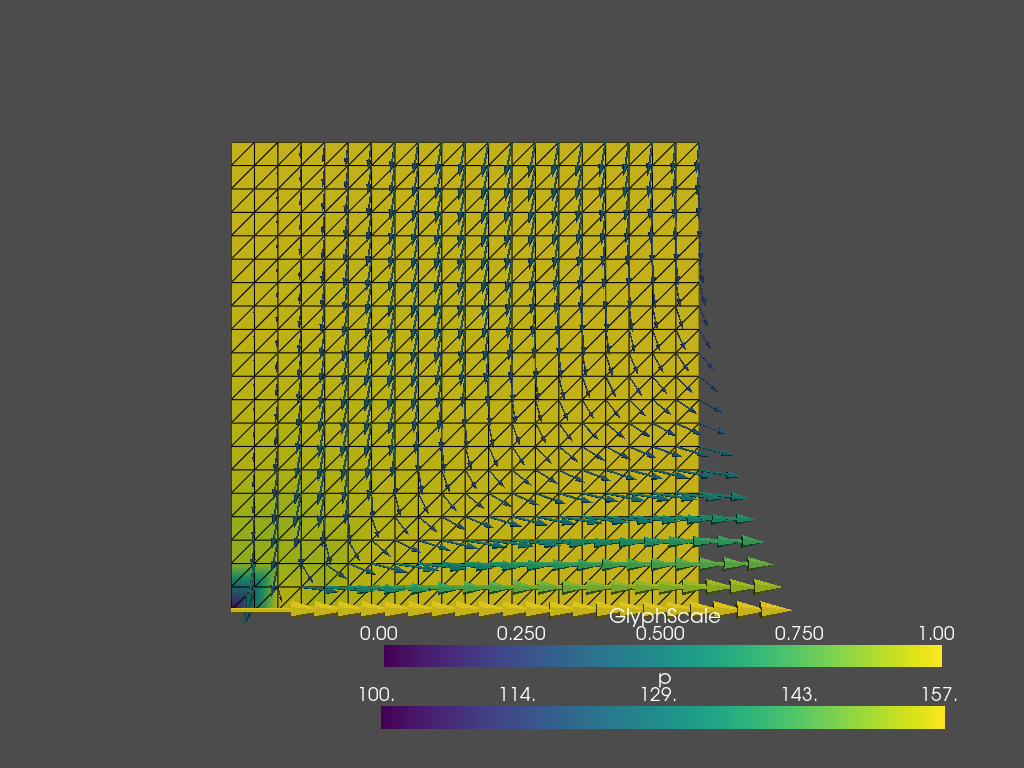

In [5]:
import pyvista
from dolfinx.plot import create_vtk_mesh

pyvista.start_xvfb()
topology, cell_types, geometry = create_vtk_mesh(V0)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(v)] = v.x.array.real.reshape((geometry.shape[0], len(v)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["v"] = values
glyphs = function_grid.glyph(orient="v", factor=0.2)

# create a scalar field on the P2 element
p_p2 = Function(V00)
# and interpolate the pressure onto it
p_p2.interpolate(p)
# then put that pressure onto the function_grid
function_grid["p"] = p_p2.x.array.real
function_grid.set_active_scalars("p")

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(function_grid, show_edges=True)
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

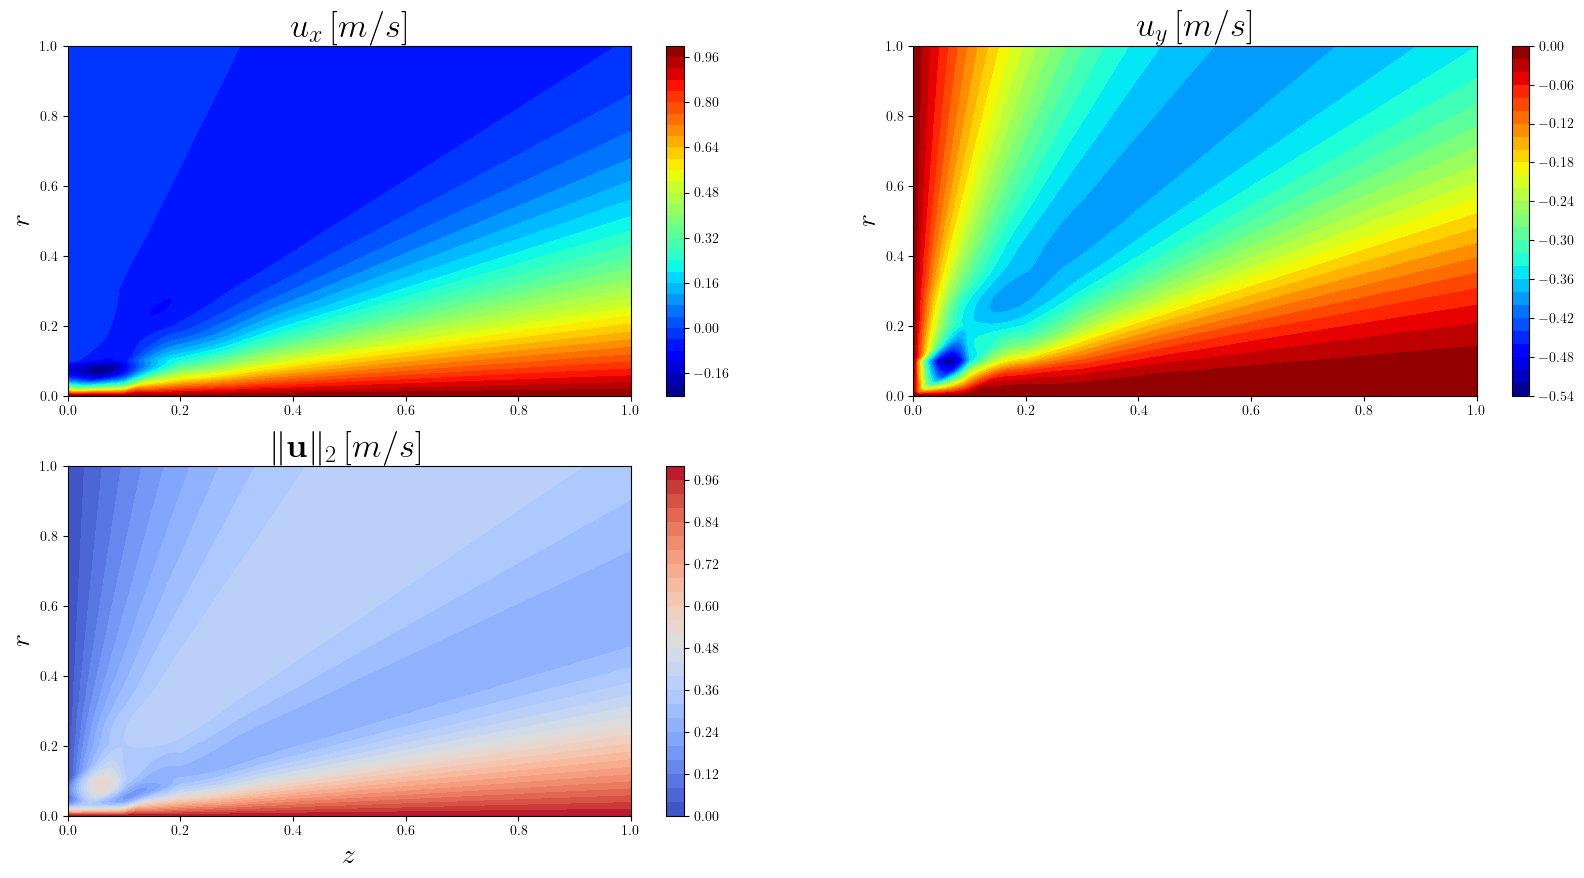

In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from scipy.interpolate import NearestNDInterpolator
import dolfinx



plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

def extractVectorField(domain, xBound, yBound, ve):
    Nx, Ny = 100, 100
    x_grid = np.linspace(xBound[0], xBound[1], Nx)
    y_grid = np.linspace(yBound[0], yBound[1], Ny)
    
    u_x = np.zeros((Nx, Ny))
    u_y = np.zeros_like(u_x)

    for ii in range(Nx):
        points = np.zeros((3, Ny))
        points[0, :] = x_grid[ii]
        points[1, :] = y_grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        u_x[ii, :] = ve.eval(xPlot, cells)[:, 0]
        u_y[ii, :] = ve.eval(xPlot, cells)[:, 1]

    u_x_grid = np.zeros((Nx * Ny))
    u_y_grid = np.zeros_like(u_x_grid)
    x_y_grid = np.zeros((Nx * Ny, 2))

    idx = 0

    for ii in range(Nx):
        for jj in range(Ny):
            u_x_grid[idx] = u_x[ii, jj]
            u_y_grid[idx] = u_y[ii, jj]

            x_y_grid[idx, 0] = x_grid[ii]
            x_y_grid[idx, 1] = y_grid[jj]

            idx += 1

    return NearestNDInterpolator(x_y_grid, u_x_grid), NearestNDInterpolator(x_y_grid, u_y_grid)


xBound = np.array([0., 1.])
yBound = np.array([0., 1.])
ux_fun, uy_fun = extractVectorField(domain, xBound, yBound, v)


##############################################################################

xPlot = np.linspace(xBound[0], xBound[1], 100)
yPlot = np.linspace(yBound[0], yBound[1], 100)

X, Y = np.meshgrid(xPlot, yPlot)

_figure = plt.figure( figsize = (20,10) )
plt.subplot(2,2,1)
plt.contourf(X, Y, ux_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_x\,[m/s]$', fontsize = 25)
                         
plt.subplot(2,2,2)
plt.contourf(X, Y, uy_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_y\,[m/s]$', fontsize = 25)

plt.subplot(2,2,3)
plt.contourf(X, Y, np.sqrt(ux_fun(X,Y)**2 + uy_fun(X,Y)**2), cmap='coolwarm', levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.xlabel(r'$z$', fontsize = 20)
plt.title(r'$\|\mathbf{u}\|_2\,[m/s]$', fontsize = 25)

_figure.savefig('Stokes_blockDirect.pdf', format='pdf', dpi=600, bbox_inches='tight')

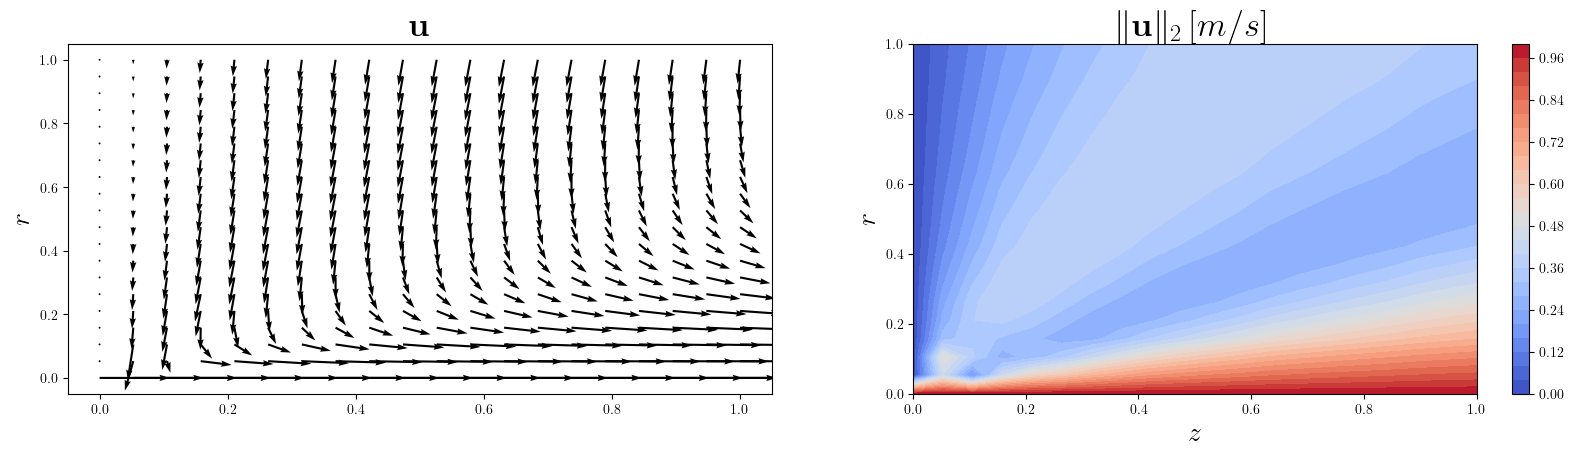

In [16]:
xPlot = np.linspace(xBound[0], xBound[1], 20)
yPlot = np.linspace(yBound[0], yBound[1], 20)

X, Y = np.meshgrid(xPlot, yPlot)

_figure = plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.quiver(X, Y, ux_fun(X, Y), uy_fun(X, Y), scale=10)
plt.ylabel(r'$r$', fontsize=20)
plt.title(r'$\mathbf{u}$', fontsize=25)

plt.subplot(2, 2, 2)
plt.contourf(X, Y, np.sqrt(ux_fun(X, Y)**2 + uy_fun(X, Y)**2), cmap='coolwarm', levels=30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize=20)
plt.xlabel(r'$z$', fontsize=20)
plt.title(r'$\|\mathbf{u}\|_2\,[m/s]$', fontsize=25)

_figure.savefig('BatchelorCornerflow.pdf', format='pdf', dpi=600, bbox_inches='tight')

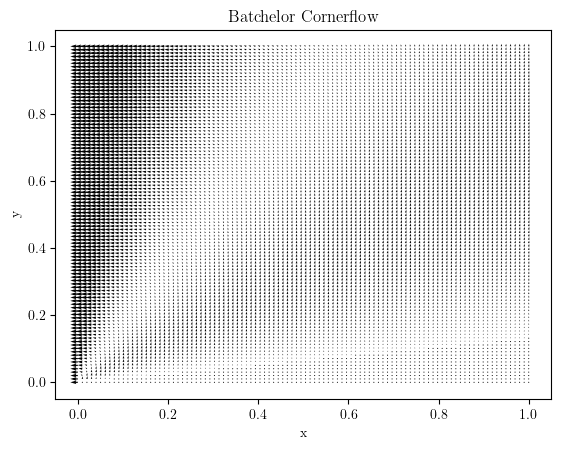

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the mesh coordinates
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the velocity field at each mesh point
Ue = 1.0  # Define the velocity magnitude
theta0 = 0.5 * np.pi
theta = np.arctan2(X, Y)
radius = (X ** 2 + Y ** 2) ** 0.5
f = Ue * (-theta0 ** 2 * np.sin(theta) + theta0 * theta * np.sin(theta)
          - np.sin(theta0) * np.cos(theta0) * theta * np.sin(theta)
          + np.sin(theta0) ** 2 * theta * np.cos(theta)) / (theta0 ** 2 - np.sin(theta0) ** 2)

vre = Ue * (-theta0 ** 2 * np.cos(theta) + theta0 * np.sin(theta)
            + theta0 * theta * np.cos(theta) - np.sin(theta0) * np.cos(theta0) * np.sin(theta)
            - np.sin(theta0) * np.cos(theta0) * theta * np.cos(theta)
            + np.sin(theta0) ** 2 * np.cos(theta) - np.sin(theta0) ** 2 * theta * np.sin(theta)) \
      / (theta0 ** 2 - np.sin(theta0) ** 2)
vte = -f
ve = np.array([vre * np.cos(theta) - vte * np.sin(theta),
               vre * np.sin(theta) + vte * np.cos(theta)])

# Plot the velocity field
fig, ax = plt.subplots()
ax.quiver(X, Y, ve[0], ve[1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Batchelor Cornerflow')
plt.show()
_figure.savefig('BatchelorCornerflow_subplots.pdf', format='pdf', dpi=600, bbox_inches='tight')